1 :Cleaning

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import datetime

load_dotenv()

file_path = os.getenv("CSV_PATH")
print(f"chemin du fichier : {file_path}")
chocolate_dataset = pd.read_csv(file_path)
print(chocolate_dataset.head())

chemin du fichier : ../data/Chocolate_sales.csv
     Sales Person    Country              Product        Date      Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco  04/01/2022   $5,320.00   
1     Van Tuxwell      India        85% Dark Bars  01/08/2022   $7,896.00   
2    Gigi Bohling      India  Peanut Butter Cubes  07/07/2022   $4,501.00   
3    Jan Morforth  Australia  Peanut Butter Cubes  27/04/2022  $12,726.00   
4  Jehu Rudeforth         UK  Peanut Butter Cubes  24/02/2022  $13,685.00   

   Boxes Shipped  
0            180  
1             94  
2             91  
3            342  
4            184  


## Nettoyer le fichier

In [2]:
chocolate_dataset["Amount"] = chocolate_dataset["Amount"].str.replace('$', '')
chocolate_dataset["Amount"] = chocolate_dataset["Amount"].str.replace(',', '')
chocolate_dataset["Amount"] = pd.to_numeric(chocolate_dataset["Amount"], downcast = 'float', errors = 'coerce')
print(chocolate_dataset.head())

     Sales Person    Country              Product        Date   Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco  04/01/2022   5320.0   
1     Van Tuxwell      India        85% Dark Bars  01/08/2022   7896.0   
2    Gigi Bohling      India  Peanut Butter Cubes  07/07/2022   4501.0   
3    Jan Morforth  Australia  Peanut Butter Cubes  27/04/2022  12726.0   
4  Jehu Rudeforth         UK  Peanut Butter Cubes  24/02/2022  13685.0   

   Boxes Shipped  
0            180  
1             94  
2             91  
3            342  
4            184  


## Nettoyer les dates

In [3]:
chocolate_dataset["Date"] = pd.to_datetime(chocolate_dataset["Date"], format="%d/%m/%Y")
print(chocolate_dataset["Date"].head())

0   2022-01-04
1   2022-08-01
2   2022-07-07
3   2022-04-27
4   2022-02-24
Name: Date, dtype: datetime64[ns]


## Contrôle Qualité

In [4]:
def find_void(serie):
    return serie[serie.isnull()]
#vérifions la complétude
def find_negatives(serie):
    return serie[serie < 0]

boxes_shipped_void = find_void(chocolate_dataset["Boxes Shipped"])
boxes_shipped_negatives = find_negatives(chocolate_dataset["Boxes Shipped"])

Amount_void = find_void(chocolate_dataset["Amount"])
Amount_negatives = find_negatives(chocolate_dataset["Amount"])

print(f"taux de valeurs manquantes : \nBoxes Shipped : {boxes_shipped_void.shape[0]} , Amount : {Amount_negatives.shape[0]}")
print(f"taux de valeurs négatives : \nBoxes Shipped : {boxes_shipped_negatives.shape[0]} , Amount : {Amount_negatives.shape[0]}")


taux de valeurs manquantes : 
Boxes Shipped : 0 , Amount : 0
taux de valeurs négatives : 
Boxes Shipped : 0 , Amount : 0


## Feature Engineering

In [5]:
#recupérer année, mois
chocolate_dataset["Month"] = chocolate_dataset["Date"].dt.month
chocolate_dataset["Year"] = chocolate_dataset["Date"].dt.year
print(chocolate_dataset["Year"].head())



0    2022
1    2022
2    2022
3    2022
4    2022
Name: Year, dtype: int32


Créer une catégorie produit plus simple

In [6]:
chocolate_dataset["Product Category"] = "Other"
chocolate_dataset.loc[chocolate_dataset["Product"].str.contains("Dark", case=False, na=False), "Product Category"] = "Dark Choco"
chocolate_dataset.loc[chocolate_dataset["Product"].str.contains("Nut|Peanut|Almond", case=False, na=False), "Product Category"] = "Nut Choco"
chocolate_dataset.loc[chocolate_dataset["Product"].str.contains("Dark", case=False, na=False), "Product Category"] = "White Choco"

print(chocolate_dataset["Product Category"].head())

0          Other
1    White Choco
2      Nut Choco
3      Nut Choco
4      Nut Choco
Name: Product Category, dtype: object


Price per Box

In [7]:
chocolate_dataset["Price_Per_Box"] = chocolate_dataset["Amount"] / chocolate_dataset["Boxes Shipped"]
print(chocolate_dataset["Price_Per_Box"].head())

0    29.555556
1    84.000000
2    49.461538
3    37.210526
4    74.375000
Name: Price_Per_Box, dtype: float64


## Analyse exploratoire

['Jan' 'Aug' 'Jul' 'Apr' 'Feb' 'Jun' 'Mar' 'May']
Month
Apr    64216
Aug    60682
Feb    54917
Jan    84162
Jul    69808
Jun    80357
Mar    59633
May    66662
Name: Boxes Shipped, dtype: int64


<Axes: xlabel='Month'>

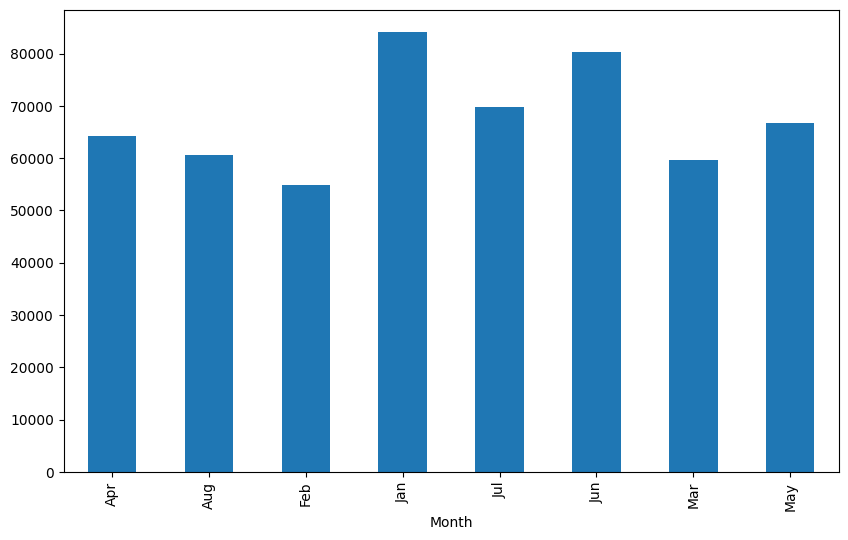

In [ ]:
#Saisonnalité
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
chocolate_dataset["Month"] = pd.to_datetime(chocolate_dataset["Month"], format='%m').dt.strftime('%b')
chocolate_dataset["Month"] = pd.Categorical(
    chocolate_dataset["Month"],
    categories=month_order,
    ordered = True
)
ventes_par_mois = chocolate_dataset.groupby("Month")["Boxes Shipped"].sum()
print(chocolate_dataset["Month"].unique())
print(ventes_par_mois)
ventes_par_mois.plot(kind="bar", figsize=(10,6))